In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [36]:


# Tạo hàm chuẩn bị dữ liệu cho mô hình
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Define GRU Model
def build_and_train_model(X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    model = Sequential()
    model.add(GRU(64, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)
    return model, history

def predict_and_evaluate(model, X_train, X_test, scaler):
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    y_pred = scaler.inverse_transform(y_pred)
    return train_predict, y_pred

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def forecast_next_days(model, data, scaler, n_steps=100, days=30):
    x_input = data[-n_steps:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []
    i = 0
    while i < days:
        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

def plot_results(dates, actual, train, test, predict, future_30, future_60, future_90, title):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, actual, label='Dữ liệu huấn luyện', color='green')
    plt.plot(dates[len(train):len(train) + len(test)], test, label='Dữ liệu kiểm thử', color='red')
    plt.plot(dates[len(train):len(train) + len(predict)], predict, label='Dữ liệu dự đoán', color='blue')

    future_dates_30 = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=len(future_30), freq='D')
    future_dates_60 = pd.date_range(future_dates_30[-1] + pd.Timedelta(days=1), periods=len(future_60), freq='D')
    future_dates_90 = pd.date_range(future_dates_60[-1] + pd.Timedelta(days=1), periods=len(future_90), freq='D')

    plt.plot(future_dates_30, future_30, label='Dự đoán 30 ngày', color='darkred')
    plt.plot(future_dates_60, np.concatenate((future_30[-1:], future_60)).reshape(-1)[:len(future_60)], label='Dự đoán 60 ngày', color='orange')
    plt.plot(future_dates_90, np.concatenate((future_60[-1:], future_90)).reshape(-1)[:len(future_90)], label='Dự đoán 90 ngày', color='purple')

    plt.title(title)
    plt.xlabel('Ngày')
    plt.ylabel('Giá (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Đọc dataset vàng
data = pd.read_csv('/content/gold_price_2018_2024.csv')
df_value = data.reset_index()['Value (USD per troy ounce)']

def train_and_evaluate_gold(train_ratio):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_value_scaled = scaler.fit_transform(np.array(df_value).reshape(-1, 1))
    train_size = int(len(data_value_scaled) * train_ratio)
    test_size = len(data_value_scaled) - train_size
    train, test = data_value_scaled[:train_size, :], data_value_scaled[train_size:, :]
    time_step = 100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model, history = build_and_train_model(X_train, y_train, X_test, y_test, time_step)
    train_predict, y_pred = predict_and_evaluate(model, X_train, X_test, scaler)
    test_rmse = calculate_rmse(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Gold RMSE:', test_rmse)
    mae = calculate_mae(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Gold MAE:', mae)
    mape = calculate_mape(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Gold MAPE:', mape)
    next_30_days = forecast_next_days(model, test, scaler, days=30)
    next_60_days = forecast_next_days(model, test, scaler, days=60)
    next_90_days = forecast_next_days(model, test, scaler, days=90)
    dates = pd.to_datetime(data['Date'].values)
    train_actual = scaler.inverse_transform(train)
    test_actual = scaler.inverse_transform(test)
    all_actual = np.concatenate((train_actual, test_actual))

    # Tính toán tỷ lệ train-test
    train_ratio_display = round(train_ratio * 10)
    test_ratio_display = round((1 - train_ratio) * 10)

    # Đảm bảo tỷ lệ luôn có tổng là 10
    if train_ratio_display + test_ratio_display != 10:
        train_ratio_display = 10 - test_ratio_display
    plot_results(dates[:len(all_actual)], all_actual, train_actual, test_actual, y_pred, next_30_days, next_60_days, next_90_days, 'Dự đoán giá vàng {}:{} (GRU)'.format(train_ratio_display, test_ratio_display))


Epoch 1/100
49/49 [==============================] - 14s 155ms/step - loss: 0.0143 - val_loss: 7.1440e-04
Epoch 2/100
49/49 [==============================] - 6s 121ms/step - loss: 3.4916e-04 - val_loss: 2.8335e-04
Epoch 3/100
49/49 [==============================] - 6s 118ms/step - loss: 2.3582e-04 - val_loss: 2.6835e-04
Epoch 4/100
49/49 [==============================] - 2s 51ms/step - loss: 2.1412e-04 - val_loss: 2.4824e-04
Epoch 5/100
49/49 [==============================] - 2s 48ms/step - loss: 2.0170e-04 - val_loss: 2.8059e-04
Epoch 6/100
49/49 [==============================] - 2s 51ms/step - loss: 1.9604e-04 - val_loss: 2.2325e-04
Epoch 7/100
49/49 [==============================] - 3s 65ms/step - loss: 2.0110e-04 - val_loss: 2.2284e-04
Epoch 8/100
49/49 [==============================] - 4s 73ms/step - loss: 1.8298e-04 - val_loss: 2.5991e-04
Epoch 9/100
49/49 [==============================] - 2s 51ms/step - loss: 1.7877e-04 - val_loss: 2.1627e-04
Epoch 10/100
49/49 [========

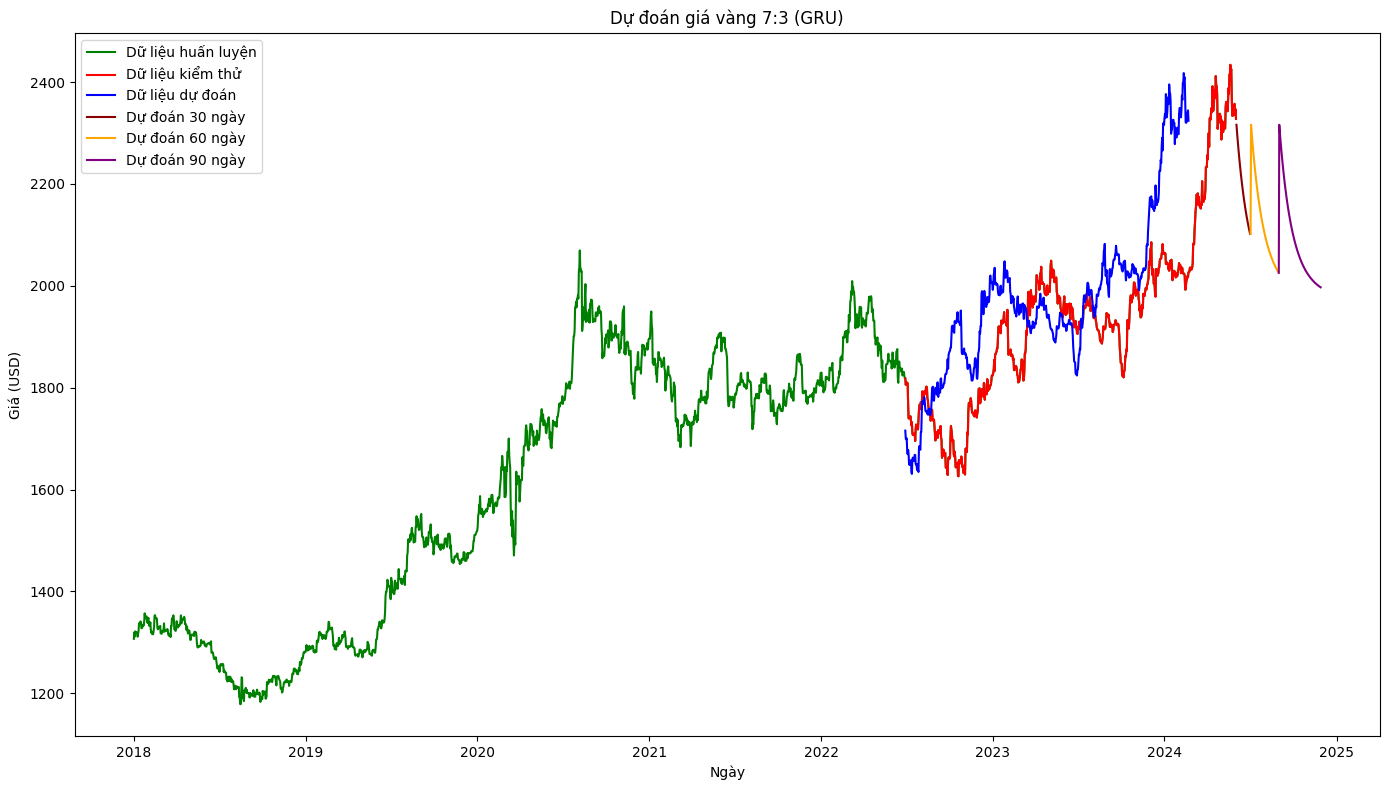

In [37]:
# Train and evaluate for different ratios
train_and_evaluate_gold(0.7)

Epoch 1/100
56/56 [==============================] - 8s 99ms/step - loss: 0.0325 - val_loss: 0.0046
Epoch 2/100
56/56 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 3.3854e-04
Epoch 3/100
56/56 [==============================] - 3s 50ms/step - loss: 2.7178e-04 - val_loss: 3.1993e-04
Epoch 4/100
56/56 [==============================] - 3s 53ms/step - loss: 2.5148e-04 - val_loss: 2.7537e-04
Epoch 5/100
56/56 [==============================] - 3s 61ms/step - loss: 2.3882e-04 - val_loss: 2.5880e-04
Epoch 6/100
56/56 [==============================] - 4s 73ms/step - loss: 2.2601e-04 - val_loss: 2.5172e-04
Epoch 7/100
56/56 [==============================] - 3s 50ms/step - loss: 2.1411e-04 - val_loss: 2.8907e-04
Epoch 8/100
56/56 [==============================] - 3s 51ms/step - loss: 2.1679e-04 - val_loss: 2.5187e-04
Epoch 9/100
56/56 [==============================] - 3s 57ms/step - loss: 2.0273e-04 - val_loss: 2.1350e-04
Epoch 10/100
56/56 [====================

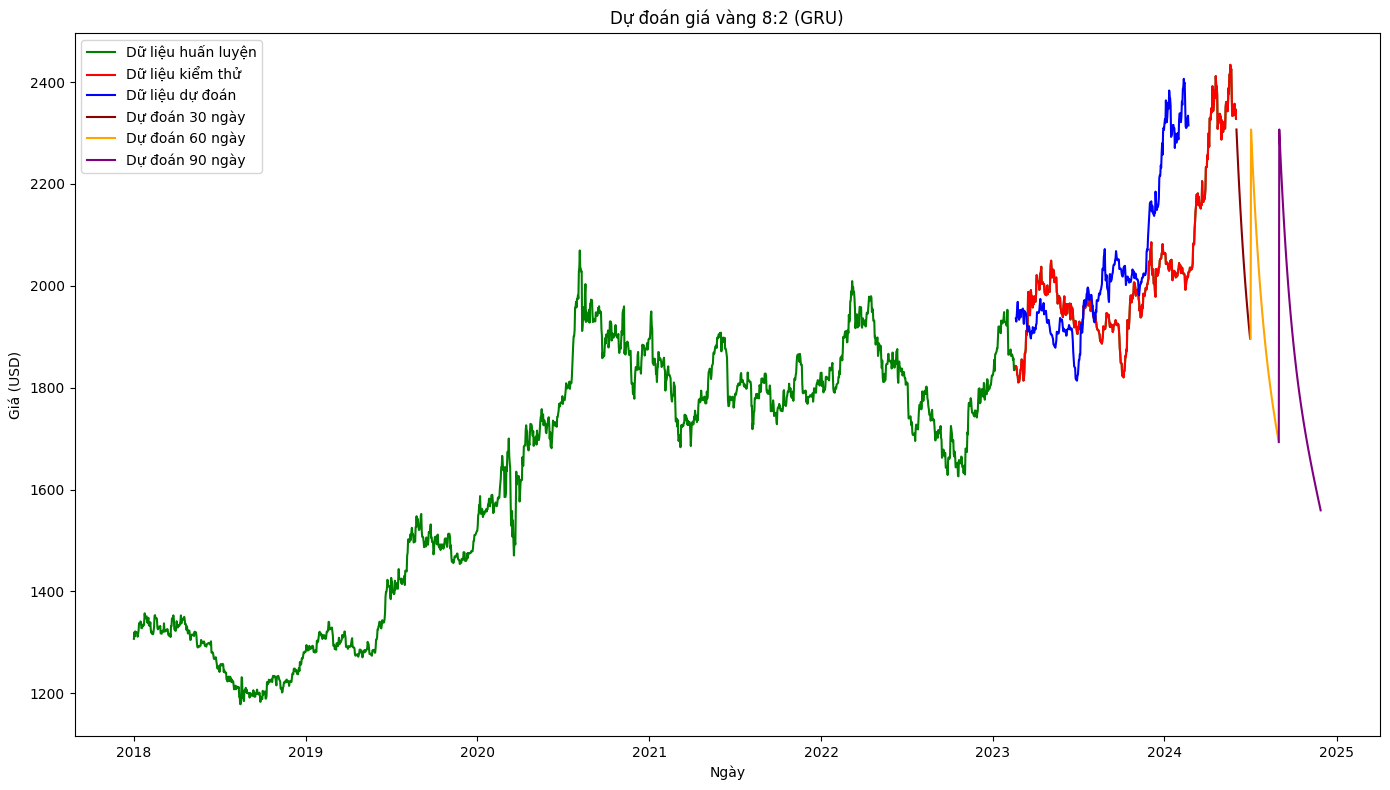

In [38]:
# Train and evaluate for different ratios
train_and_evaluate_gold(0.8)

Epoch 1/100
63/63 [==============================] - 7s 79ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 2/100
63/63 [==============================] - 3s 47ms/step - loss: 2.2829e-04 - val_loss: 4.5259e-04
Epoch 3/100
63/63 [==============================] - 3s 46ms/step - loss: 1.9031e-04 - val_loss: 3.3456e-04
Epoch 4/100
63/63 [==============================] - 3s 45ms/step - loss: 1.8081e-04 - val_loss: 4.5939e-04
Epoch 5/100
63/63 [==============================] - 4s 66ms/step - loss: 1.7739e-04 - val_loss: 3.1141e-04
Epoch 6/100
63/63 [==============================] - 3s 50ms/step - loss: 1.6764e-04 - val_loss: 3.8404e-04
Epoch 7/100
63/63 [==============================] - 3s 45ms/step - loss: 1.5981e-04 - val_loss: 2.5729e-04
Epoch 8/100
63/63 [==============================] - 3s 43ms/step - loss: 1.5820e-04 - val_loss: 3.6682e-04
Epoch 9/100
63/63 [==============================] - 4s 60ms/step - loss: 1.5208e-04 - val_loss: 2.4238e-04
Epoch 10/100
63/63 [================

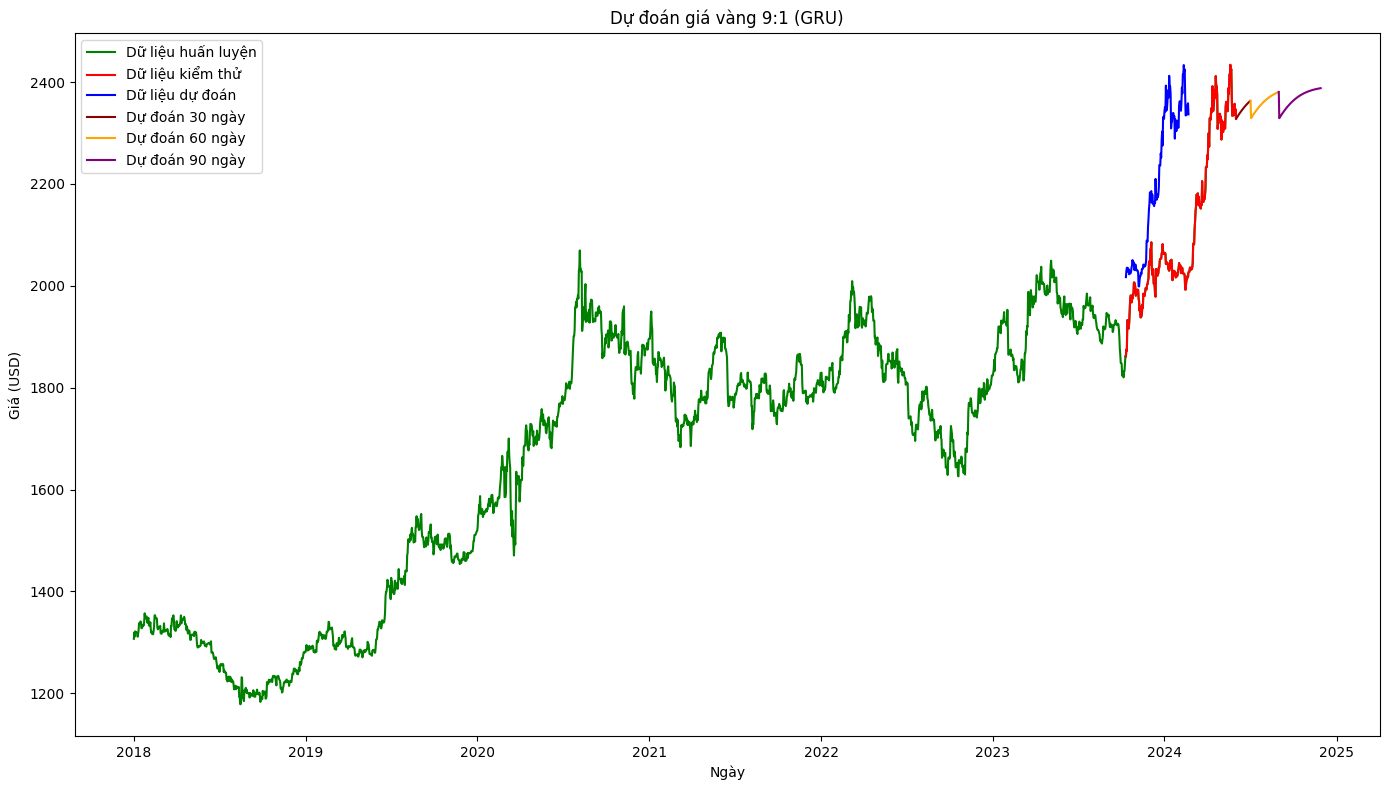

In [39]:
# Train and evaluate for different ratios
train_and_evaluate_gold(0.9)

SILVER PRICE

In [53]:


# Đọc dataset bạc
data = pd.read_csv('/content/silver_price_2018_2024.csv')
df_value = data.reset_index()['Value (USD per troy ounce)']

def train_and_evaluate_silver(train_ratio):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_value_scaled = scaler.fit_transform(np.array(df_value).reshape(-1, 1))
    train_size = int(len(data_value_scaled) * train_ratio)
    test_size = len(data_value_scaled) - train_size
    train, test = data_value_scaled[:train_size, :], data_value_scaled[train_size:, :]
    time_step = 100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model, history = build_and_train_model(X_train, y_train, X_test, y_test, time_step)
    train_predict, y_pred = predict_and_evaluate(model, X_train, X_test, scaler)
    test_rmse = calculate_rmse(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Silver RMSE:', test_rmse)
    mae = calculate_mae(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Silver MAE:', mae)
    mape = calculate_mape(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Silver MAPE:', mape)
    next_30_days = forecast_next_days(model, test, scaler, days=30)
    next_60_days = forecast_next_days(model, test, scaler, days=60)
    next_90_days = forecast_next_days(model, test, scaler, days=90)
    dates = pd.to_datetime(data['Date'].values)
    train_actual = scaler.inverse_transform(train)
    test_actual = scaler.inverse_transform(test)
    all_actual = np.concatenate((train_actual, test_actual))

    # Tính toán tỷ lệ train-test
    train_ratio_display = round(train_ratio * 10)
    test_ratio_display = round((1 - train_ratio) * 10)

    # Đảm bảo tỷ lệ luôn có tổng là 10
    if train_ratio_display + test_ratio_display != 10:
        train_ratio_display = 10 - test_ratio_display
    plot_results(dates[:len(all_actual)], all_actual, train_actual, test_actual, y_pred, next_30_days, next_60_days, next_90_days, 'Dự đoán giá bạc {}:{} (GRU)'.format(train_ratio_display, test_ratio_display))


Epoch 1/100
49/49 [==============================] - 6s 68ms/step - loss: 0.0240 - val_loss: 0.0011
Epoch 2/100
49/49 [==============================] - 4s 78ms/step - loss: 0.0011 - val_loss: 6.9140e-04
Epoch 3/100
49/49 [==============================] - 3s 70ms/step - loss: 5.8216e-04 - val_loss: 6.6773e-04
Epoch 4/100
49/49 [==============================] - 3s 56ms/step - loss: 5.4016e-04 - val_loss: 6.0857e-04
Epoch 5/100
49/49 [==============================] - 3s 58ms/step - loss: 5.1546e-04 - val_loss: 6.0194e-04
Epoch 6/100
49/49 [==============================] - 3s 56ms/step - loss: 4.9019e-04 - val_loss: 5.3975e-04
Epoch 7/100
49/49 [==============================] - 4s 88ms/step - loss: 4.6984e-04 - val_loss: 5.2221e-04
Epoch 8/100
49/49 [==============================] - 3s 58ms/step - loss: 4.5507e-04 - val_loss: 4.9885e-04
Epoch 9/100
49/49 [==============================] - 3s 56ms/step - loss: 4.4297e-04 - val_loss: 5.2051e-04
Epoch 10/100
49/49 [====================

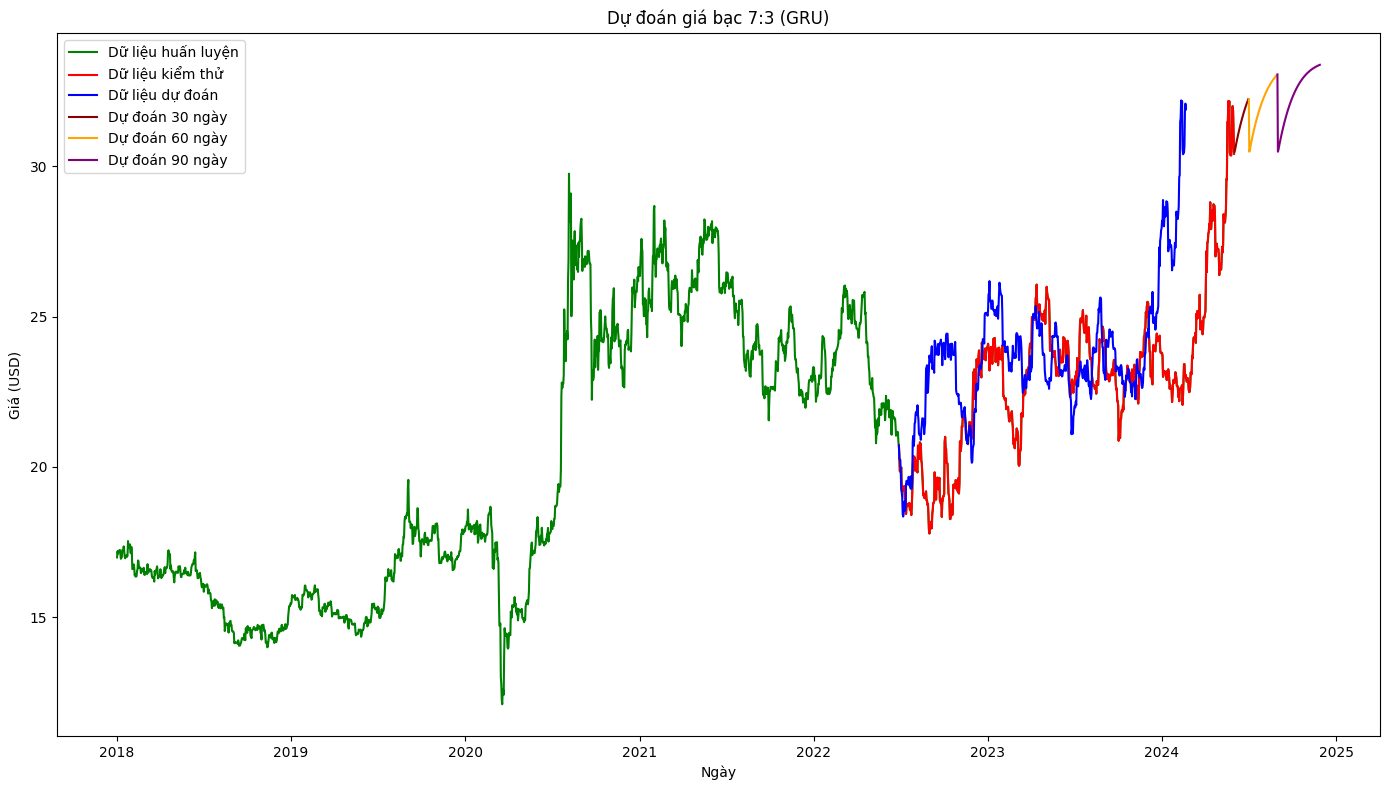

In [55]:
# Train and evaluate for different ratios
train_and_evaluate_silver(0.7)

Epoch 1/100
56/56 [==============================] - 7s 83ms/step - loss: 0.0139 - val_loss: 0.0012
Epoch 2/100
56/56 [==============================] - 3s 52ms/step - loss: 5.9278e-04 - val_loss: 5.5337e-04
Epoch 3/100
56/56 [==============================] - 3s 53ms/step - loss: 4.5282e-04 - val_loss: 5.1855e-04
Epoch 4/100
56/56 [==============================] - 3s 55ms/step - loss: 4.4169e-04 - val_loss: 4.9207e-04
Epoch 5/100
56/56 [==============================] - 5s 82ms/step - loss: 4.1250e-04 - val_loss: 4.6268e-04
Epoch 6/100
56/56 [==============================] - 3s 50ms/step - loss: 3.9361e-04 - val_loss: 4.4076e-04
Epoch 7/100
56/56 [==============================] - 3s 52ms/step - loss: 3.8555e-04 - val_loss: 4.9197e-04
Epoch 8/100
56/56 [==============================] - 3s 52ms/step - loss: 3.7150e-04 - val_loss: 4.1073e-04
Epoch 9/100
56/56 [==============================] - 5s 85ms/step - loss: 3.6461e-04 - val_loss: 4.1776e-04
Epoch 10/100
56/56 [================

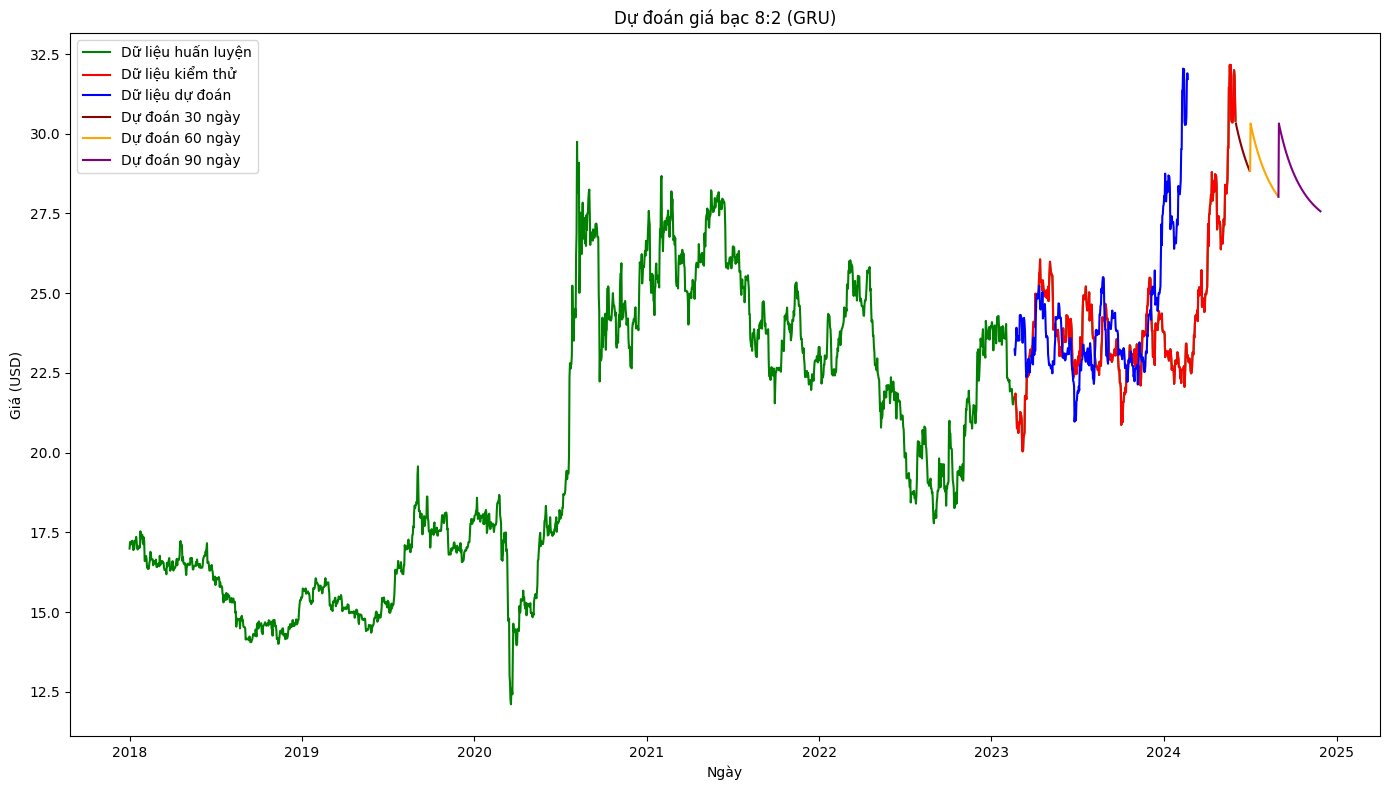

In [54]:
# Train and evaluate for different ratios
train_and_evaluate_silver(0.8)

Epoch 1/100
63/63 [==============================] - 6s 57ms/step - loss: 0.0329 - val_loss: 0.0039
Epoch 2/100
63/63 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 9.8333e-04
Epoch 3/100
63/63 [==============================] - 5s 78ms/step - loss: 6.1954e-04 - val_loss: 0.0011
Epoch 4/100
63/63 [==============================] - 3s 48ms/step - loss: 5.7578e-04 - val_loss: 0.0011
Epoch 5/100
63/63 [==============================] - 3s 52ms/step - loss: 5.2998e-04 - val_loss: 9.0906e-04
Epoch 6/100
63/63 [==============================] - 3s 54ms/step - loss: 5.1731e-04 - val_loss: 9.6301e-04
Epoch 7/100
63/63 [==============================] - 5s 81ms/step - loss: 4.9019e-04 - val_loss: 7.0968e-04
Epoch 8/100
63/63 [==============================] - 3s 52ms/step - loss: 4.6854e-04 - val_loss: 7.4017e-04
Epoch 9/100
63/63 [==============================] - 3s 51ms/step - loss: 4.4718e-04 - val_loss: 6.6798e-04
Epoch 10/100
63/63 [============================

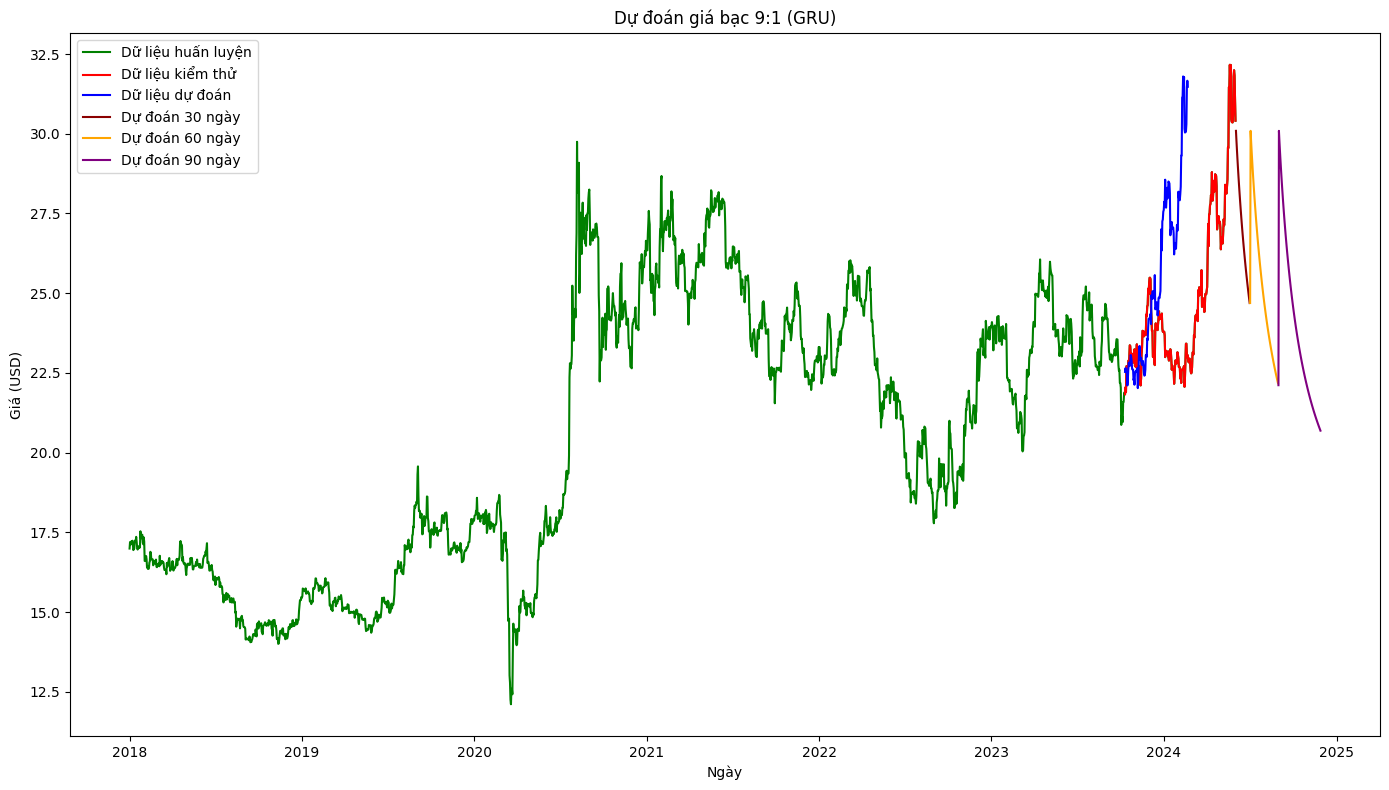

In [56]:
# Train and evaluate for different ratios
train_and_evaluate_silver(0.9)

PLATINUM PRICE

In [50]:


# Đọc dataset bạc
data = pd.read_csv('/content/platium_price_2018_2024.csv')
df_value = data.reset_index()['Value (USD per troy ounce)']

def train_and_evaluate_pt(train_ratio):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_value_scaled = scaler.fit_transform(np.array(df_value).reshape(-1, 1))
    train_size = int(len(data_value_scaled) * train_ratio)
    test_size = len(data_value_scaled) - train_size
    train, test = data_value_scaled[:train_size, :], data_value_scaled[train_size:, :]
    time_step = 100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    model, history = build_and_train_model(X_train, y_train, X_test, y_test, time_step)
    train_predict, y_pred = predict_and_evaluate(model, X_train, X_test, scaler)
    test_rmse = calculate_rmse(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Pt RMSE:', test_rmse)
    mae = calculate_mae(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Pt MAE:', mae)
    mape = calculate_mape(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred)
    print('Pt MAPE:', mape)
    next_30_days = forecast_next_days(model, test, scaler, days=30)
    next_60_days = forecast_next_days(model, test, scaler, days=60)
    next_90_days = forecast_next_days(model, test, scaler, days=90)
    dates = pd.to_datetime(data['Date'].values)
    train_actual = scaler.inverse_transform(train)
    test_actual = scaler.inverse_transform(test)
    all_actual = np.concatenate((train_actual, test_actual))

    # Tính toán tỷ lệ train-test
    train_ratio_display = round(train_ratio * 10)
    test_ratio_display = round((1 - train_ratio) * 10)

    # Đảm bảo tỷ lệ luôn có tổng là 10
    if train_ratio_display + test_ratio_display != 10:
        train_ratio_display = 10 - test_ratio_display
    plot_results(dates[:len(all_actual)], all_actual, train_actual, test_actual, y_pred, next_30_days, next_60_days, next_90_days, 'Dự đoán giá bạch kim {}:{} (GRU)'.format(train_ratio_display, test_ratio_display))


Epoch 1/100
49/49 [==============================] - 7s 96ms/step - loss: 0.0578 - val_loss: 0.0028
Epoch 2/100
49/49 [==============================] - 2s 51ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 3/100
49/49 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 7.9567e-04
Epoch 4/100
49/49 [==============================] - 3s 55ms/step - loss: 9.0601e-04 - val_loss: 7.3795e-04
Epoch 5/100
49/49 [==============================] - 3s 61ms/step - loss: 8.1359e-04 - val_loss: 7.2193e-04
Epoch 6/100
49/49 [==============================] - 4s 81ms/step - loss: 7.8275e-04 - val_loss: 7.0332e-04
Epoch 7/100
49/49 [==============================] - 2s 49ms/step - loss: 7.3234e-04 - val_loss: 6.5715e-04
Epoch 8/100
49/49 [==============================] - 3s 53ms/step - loss: 7.0552e-04 - val_loss: 6.1794e-04
Epoch 9/100
49/49 [==============================] - 3s 51ms/step - loss: 6.9100e-04 - val_loss: 5.9831e-04
Epoch 10/100
49/49 [============================

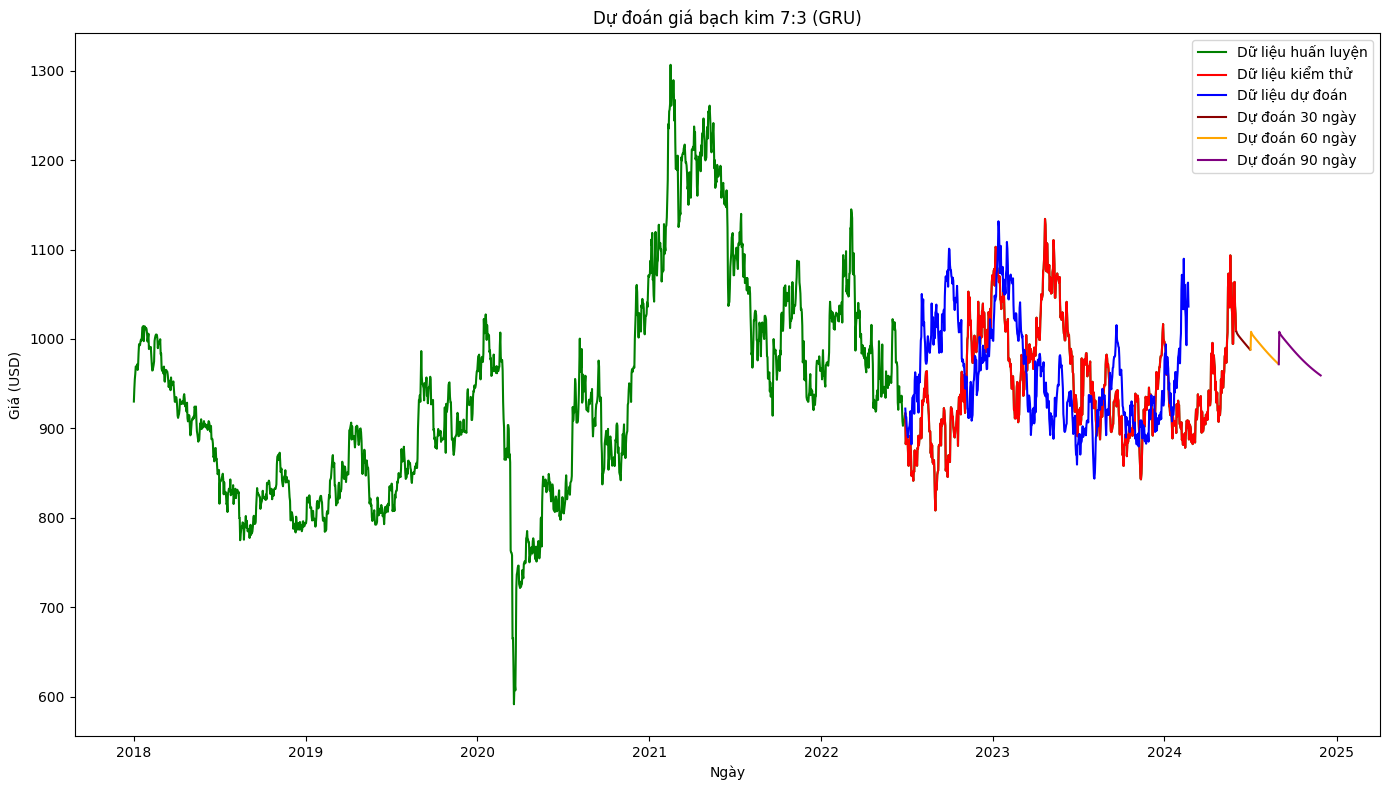

In [49]:
# Train and evaluate for different ratios
train_and_evaluate_pt(0.7)

Epoch 1/100
56/56 [==============================] - 14s 162ms/step - loss: 0.0186 - val_loss: 8.7233e-04
Epoch 2/100
56/56 [==============================] - 3s 49ms/step - loss: 0.0015 - val_loss: 5.8668e-04
Epoch 3/100
56/56 [==============================] - 3s 48ms/step - loss: 7.3706e-04 - val_loss: 5.5890e-04
Epoch 4/100
56/56 [==============================] - 3s 53ms/step - loss: 6.4555e-04 - val_loss: 5.3847e-04
Epoch 5/100
56/56 [==============================] - 3s 62ms/step - loss: 6.0741e-04 - val_loss: 5.2287e-04
Epoch 6/100
56/56 [==============================] - 4s 70ms/step - loss: 5.8582e-04 - val_loss: 4.9426e-04
Epoch 7/100
56/56 [==============================] - 3s 51ms/step - loss: 5.5722e-04 - val_loss: 5.0694e-04
Epoch 8/100
56/56 [==============================] - 3s 51ms/step - loss: 5.4510e-04 - val_loss: 4.7257e-04
Epoch 9/100
56/56 [==============================] - 3s 48ms/step - loss: 5.3881e-04 - val_loss: 4.6134e-04
Epoch 10/100
56/56 [==============

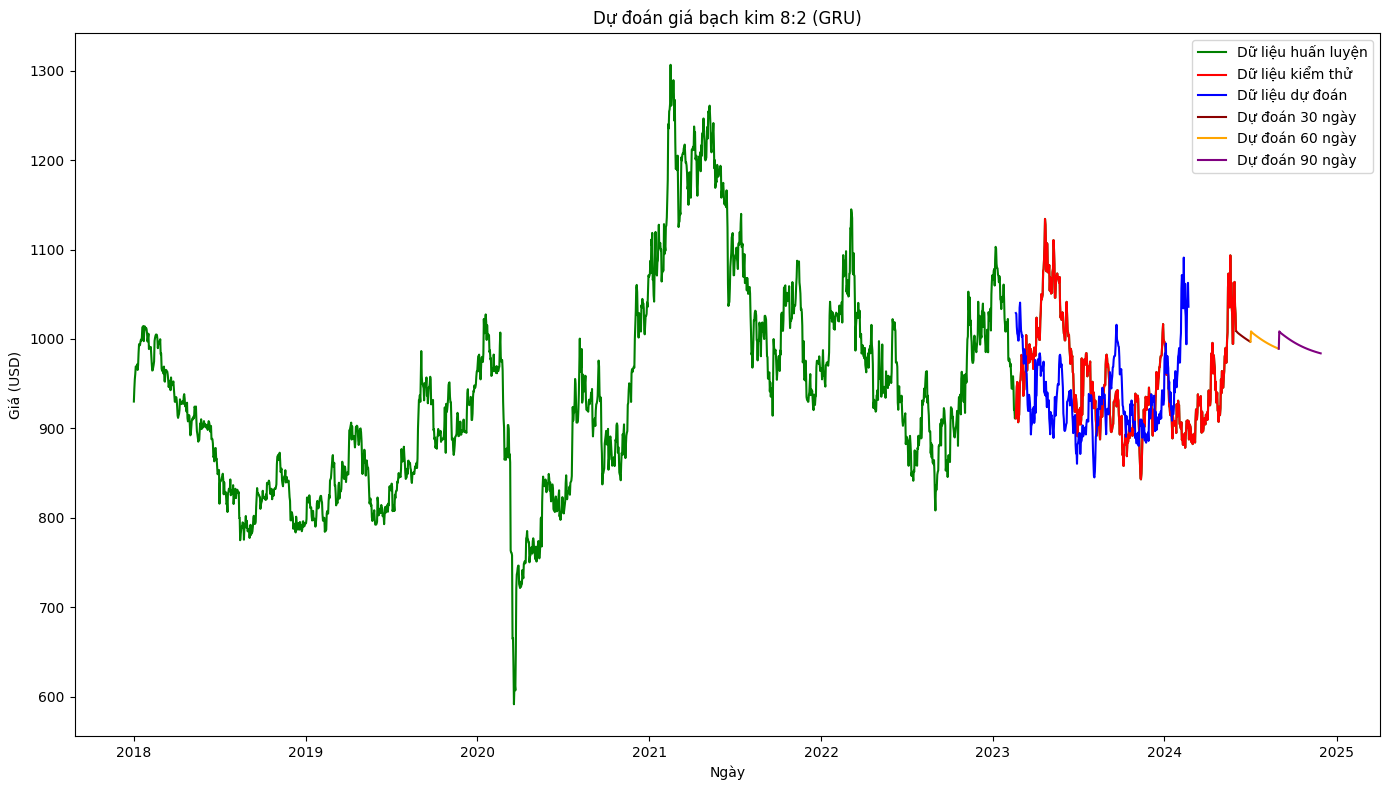

In [51]:
# Train and evaluate for different ratios
train_and_evaluate_pt(0.8)

Epoch 1/100
63/63 [==============================] - 8s 79ms/step - loss: 0.0328 - val_loss: 0.0015
Epoch 2/100
63/63 [==============================] - 3s 49ms/step - loss: 0.0027 - val_loss: 8.8892e-04
Epoch 3/100
63/63 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 7.4100e-04
Epoch 4/100
63/63 [==============================] - 4s 62ms/step - loss: 8.3002e-04 - val_loss: 7.3083e-04
Epoch 5/100
63/63 [==============================] - 4s 68ms/step - loss: 7.8959e-04 - val_loss: 7.0392e-04
Epoch 6/100
63/63 [==============================] - 3s 47ms/step - loss: 7.2571e-04 - val_loss: 6.6437e-04
Epoch 7/100
63/63 [==============================] - 3s 53ms/step - loss: 6.8335e-04 - val_loss: 6.3732e-04
Epoch 8/100
63/63 [==============================] - 4s 68ms/step - loss: 6.6521e-04 - val_loss: 6.7730e-04
Epoch 9/100
63/63 [==============================] - 4s 62ms/step - loss: 6.4479e-04 - val_loss: 5.8780e-04
Epoch 10/100
63/63 [========================

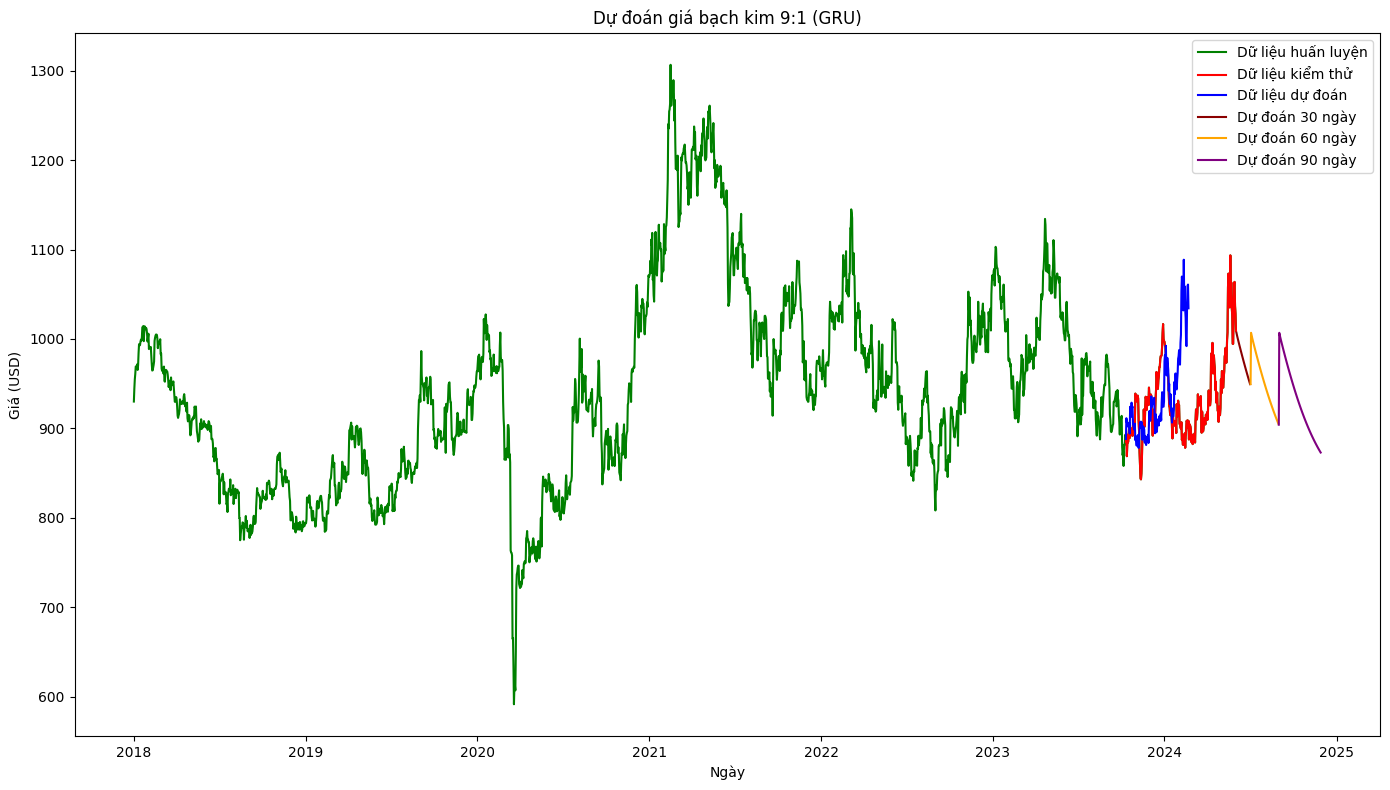

In [52]:
# Train and evaluate for different ratios
train_and_evaluate_pt(0.9)